<a id="top"></a>
# <div style="padding:20px;color:white;margin:0;font-size:36px;font-family:Georgia;text-align:center;display:fill;border-radius:5px;background-color:darkblue;overflow:hidden"><b>Genetic Algorithm for Price Optimization</b></div>

<div style="padding:20px;color:white;margin:0;font-size:24px;font-family:Georgia;text-align:center;display:fill;border-radius:5px;background-color:darkblue;overflow:hidden"><b>Subtitle</b></div>

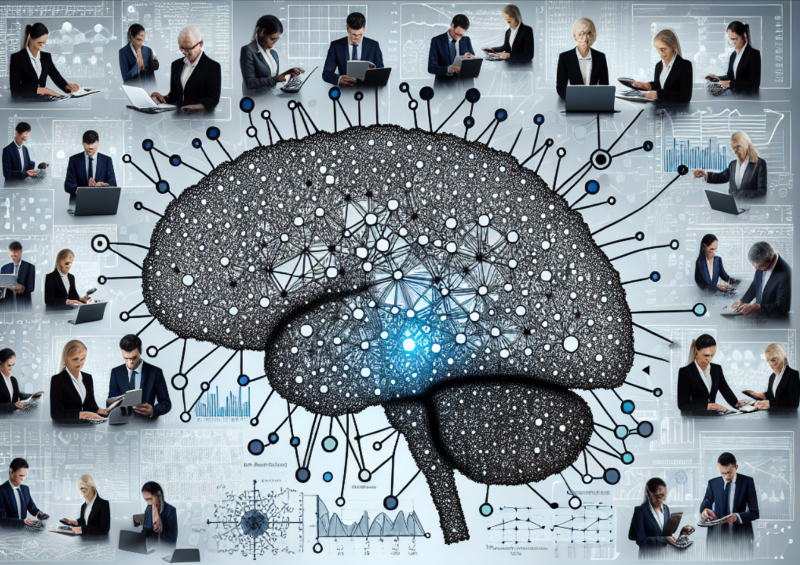  

<div style="padding:20px;color:white;margin:0;font-size:24px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:darkblue;overflow:hidden"><b>Introduction</b></div>

<div style="text-align: justify;">Intro text
</div>

<a id="top"></a>
# <div style="padding:20px;color:white;margin:0;font-size:24px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:darkblue;overflow:hidden"><b>Table of Contents</b></div>

<div style="background-color:aliceblue; padding:30px; font-size:15px;color:#034914">
    
<a id="TOC"></a>
    
* [Code setup](#code_setup)
* [Import libraries and load data](#import)
* [Data Preprocessing](#data_preprocessing)
* [Model Evaluation Functions](#model_evaluation)
* [The GLM benchmark model](#glm)
* [The Combined Actuarial Neural Network](#cann)
* [LocalGLMNet](#localglm)
* [TabNet](#tabnet)
* [Results evaluation](#results)
* [References](#ref)
* [Related Projects](#rel)

<a id="code_setup"></a>
<div style="padding:20px;color:white;margin:0;font-size:24px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:darkblue;overflow:hidden"><b>Code setup</b></div>

The python version used for this notebook is 3.10.x

We recommend to create a dedicated Conda environment for this notebook. See the example terminal commands:

Along with the python version, please install:

- Create a new conda environment named 'dl-env' with Python 3.10:
*conda create -n dl-env python=3.10*

- Activate the new environment:
*conda activate dl-env*

- Install the required packages:
*conda install pandas scikit-learn matplotlib numpy seaborn scipy*

- Install TensorFlow using pip:
*pip install tensorflow*

- Install PyTorch and torchvision for CPU only:
*conda install pytorch torchvision torchaudio cpuonly -c pytorch*

<a id="import"></a>
<div style="padding:20px;color:white;margin:0;font-size:24px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:darkblue;overflow:hidden"><b>Import libraries and load data</b></div>

In [ ]:
# Load packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import PoissonRegressor
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, mean_poisson_deviance

For simplicity and transparency, we use an open source dataset with a portfolio of car insurance policies and claims. The dataset can be loaded from the repository or it can be found on Kaggle (https://www.kaggle.com/datasets/floser/french-motor-claims-datasets-fremtpl2freq). This is a well-known and often used dataset for modelling. This provides transparency as results can be benchmarked to other work.

In [ ]:
# Load the dataset (replace with your actual file path)
data = pd.read_csv('C:/Users/bart_/Documents/git_repo/GA_for_price_optimization/data/MTPL_policy_claims_db.csv')

# Inspect the dataset
data.head()

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region
0,1.0,1,0.10,D,5,0,55,50,B12,Regular,1217,R82
1,3.0,1,0.77,D,5,0,55,50,B12,Regular,1217,R82
2,5.0,1,0.75,B,6,2,52,50,B12,Diesel,54,R22
3,10.0,1,0.09,B,7,0,46,50,B12,Diesel,76,R72
4,11.0,1,0.84,B,7,0,46,50,B12,Diesel,76,R72


In [46]:
data.shape

(678013, 12)

<a id="data_preprocessing"></a>
<div style="padding:20px;color:white;margin:0;font-size:24px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:darkblue;overflow:hidden"><b>Data Preprocessing</b></div>

The preprocessing is largely based on Richman & Wüthrich (2023), meaning that data in the tails will be right-censored. Furthermore, the Area feature is encoded to be treated as a continuous feature.

The dataset consists of a mix of numerical and categorical features. Many machine learning models cannot process categorical features in their raw format, so we need to One-Hot encode the categorical features. Furthermore, it is common the standardize numerical data before training. Both the standardization and onehot encoding are applied below in a preprocessing pipeline. 

Another important step is the creation of a train and test sample, a 90/10 split will be used.

In [ ]:
# Right-censor the data to deal with low observations
data['VehAge'] = data['VehAge'].clip(upper=20)
data['DrivAge'] = data['DrivAge'].clip(upper=90)
data['BonusMalus'] = data['BonusMalus'].clip(upper=150)

# Encode Area as continuous
area_mapping = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6}
data['Area'] = data['Area'].map(area_mapping)

# Remove missing values
data = data.dropna()

# Preprocess the Dataset
numerical_features = ['VehPower', 'VehAge', 'DrivAge', 'BonusMalus','Area']
categorical_features = ['VehBrand', 'Region','VehGas']

y = data['ClaimNb']
X = data.drop(columns=['ClaimNb', 'Exposure', 'IDpol'], axis=1)

# Create a preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ]
)

# Split the dataset including the exposure
X_train, X_test, y_train, y_test, exposure_train, exposure_test = train_test_split(
    X, y, exposure, test_size=0.1, random_state=42
)

# Apply the preprocessing pipeline
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

# Get categorical feature names from OneHotEncoder
cat_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features).tolist()

# Combine numerical and encoded categorical feature names
feature_names = numerical_features + cat_feature_names

<a id="model_evaluation"></a>
<div style="padding:20px;color:white;margin:0;font-size:24px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:darkblue;overflow:hidden"><b>Model Evaluation Functions</b></div>

In this section we will define functions that will evaluate the model performance. As evaluation metrics we chose RMSE, mean absolute error (MAE) and Poisson deviance as they are commonly used for model performance assessment. Furthermore, we define functions for graphical evaluation with quantile plots (showing actuals vs predictions) and double lift charts for model comparison. 

<a id="model_evaluation"></a>
<div style="padding:20px;color:white;margin:0;font-size:24px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:darkblue;overflow:hidden"><b>Risk premium estimation</b></div>

As a first step and benchmark we will now fit a GLM. As we are predicting claim frequency (count) we will use a Poisson distribution. For this we employ a PoissonRegressor from Scikit learn's linear model library. The only parameter that is defined in the Poisson Regressor is 'alpha', which indicates the regularization strength (the extent to which L2 penalty terms are applied). For this simple implementation we will go with traditional, unpenalized GLMs (alpha=0).  

In [51]:
# Instantiate the Poisson regressor
glm = PoissonRegressor(alpha=0)
glm.fit(X_train, y_train)

PoissonRegressor(alpha=0)

Now the GLM is fitted, we can inspect the features and coefficients:

In [52]:
# Get the coefficients from the model
coefficients = glm.coef_

# Display
coef_df = pd.DataFrame({"Feature": feature_names, "Coefficient": coefficients})
coef_df["Abs_Coefficient"] = coef_df["Coefficient"].abs()
coef_df = coef_df.sort_values(by="Abs_Coefficient", ascending=False).drop(columns="Abs_Coefficient")
print(coef_df)

           Feature  Coefficient
19      Region_R23    -0.310495
28      Region_R53     0.291609
3       BonusMalus     0.280360
31      Region_R73    -0.235607
20      Region_R24     0.233436
34      Region_R83    -0.208539
21      Region_R25     0.200424
23      Region_R31    -0.185984
33      Region_R82     0.183471
2          DrivAge     0.179089
30      Region_R72    -0.166583
1           VehAge    -0.165366
32      Region_R74     0.150778
35      Region_R91    -0.134827
14     VehBrand_B5     0.112422
27      Region_R52     0.111502
29      Region_R54     0.098630
38   VehGas_Diesel    -0.091885
10    VehBrand_B14    -0.083858
6     VehBrand_B10    -0.069260
24      Region_R41    -0.065605
18      Region_R22     0.060355
8     VehBrand_B12    -0.056526
36      Region_R93    -0.053081
4             Area     0.049917
26      Region_R43    -0.048182
25      Region_R42     0.046580
22      Region_R26    -0.043340
15     VehBrand_B6    -0.035368
5      VehBrand_B1     0.030330
11     V

For evaluation, we first need to make predictions on our test sample. When predictions on X_test are available, we can call the evaluation function and plot the double lift chart:

In [53]:
# Get GLM predictions
glm_preds_train = glm.predict(X_train)
glm_preds_test = glm.predict(X_test)

<a id="cann"></a>
<div style="padding:20px;color:white;margin:0;font-size:24px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:darkblue;overflow:hidden"><b>Conversion probabilities</b></div>

**Explanation**

texttexttext

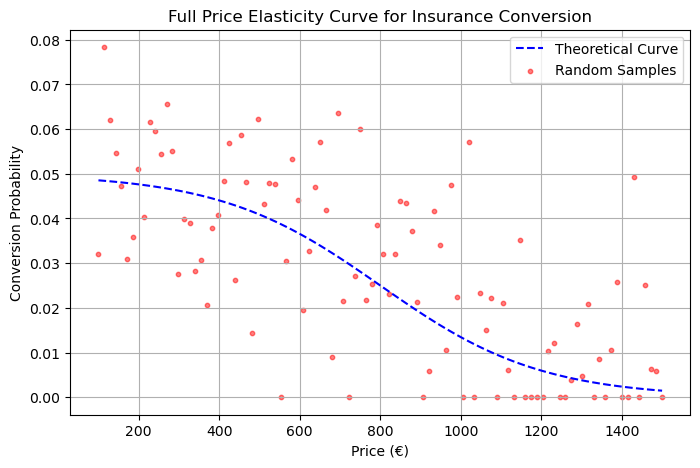

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Define extended price range
price_range = np.linspace(100, 1500, 100)  # Prices from 0 to 1000

# Define logistic function parameters
beta_0 = 4  # Adjusted intercept for relative probabilities
beta_1 = -0.005  # Reduced slope to slow down the decrease

# Define base conversion rate (real-world adjustment)
base_conversion_rate = 0.05  # Example: 10% base conversion rate

# Compute relative conversion probabilities using logistic function
relative_conversion_prob = 1 / (1 + np.exp(-(beta_0 + beta_1 * price_range)))

# Scale by base conversion rate to get actual probabilities
conversion_prob = base_conversion_rate * relative_conversion_prob

# Add random noise to simulate real-world variation
noise = np.random.normal(0, 0.02, size=conversion_prob.shape)
conversion_prob_noisy = np.clip(conversion_prob + noise, 0, 1)  # Ensure values remain in [0,1]

# Plot the full conversion probability curve
plt.figure(figsize=(8, 5))
plt.plot(price_range, conversion_prob, label="Theoretical Curve", linestyle="dashed", color="blue")
plt.scatter(price_range, conversion_prob_noisy, label="Random Samples", color="red", alpha=0.5, s=10)
plt.xlabel("Price (€)")
plt.ylabel("Conversion Probability")
plt.title("Full Price Elasticity Curve for Insurance Conversion")
plt.legend()
plt.grid()
plt.show()


<a id="localglm"></a>
<div style="padding:20px;color:white;margin:0;font-size:24px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:darkblue;overflow:hidden"><b>Genetic Algorithm</b></div>

LocalGLMNet is another hybrid model designed for actuarial applications that was developed by Richman & Wüthrich (2023). Instead of producing a single set of fixed coefficients like a traditional GLM, it learns for each data record a distribution of local coefficients. For this the model uses attention weights, which are used in a neural network to determine the importance of different parts of the input data. By multiplying the attention weights with the input data, the structure of a GLM is maintained while allowing for more complex interactions. Furthermore, the attention weights can be used to generate local explanations that can help actuaries to explain results.

<a id="results"></a>
<div style="padding:20px;color:white;margin:0;font-size:24px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:darkblue;overflow:hidden"><b>Results evaluation</b></div>

In the final section we aim to briefly discuss the model results and the pros and cons of each approach. 

<a id="ref"></a>
<div style="padding:20px;color:white;margin:0;font-size:24px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:darkblue;overflow:hidden"><b>References</b></div>

* Ronald Richman and Mario V. Wüthrich. 2023. LocalGLMnet: interpretable deep learning for tabular data. *Scandinavian Actuarial Journal* 2023(1), 71–95.

* Mario V. Wüthrich and Michael Merz. 2019. EDITORIAL: YES, WE CANN! *ASTIN Bulletin* 49(1), 1-3.

* Mario V. Wüthrich and Michael Merz. 2023. Statistical Foundations of Actuarial Learning and its Applications. Springer (open access), https://link.springer.com/book/10.1007/978-3-031-12409-9

* Sercan Arik and Tomas Pfister. 2021. TabNet: Attentive Interpretable Tabular Learning. In The Thirty-Fifth AAAI Conference on Artificial Intelligence (AAAI-21). 6679–6687.

* Kevin McDonnell, Finbarr Murphy, Barry Sheehan, Leandro Masello, and German Castignani. 2023. Deep learning in insurance: Accuracy and model interpretability using TabNet. Expert Systems with Applications 217 (5 2023), 119543.

<a id="rel"></a>
<div style="padding:20px;color:white;margin:0;font-size:24px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:darkblue;overflow:hidden"><b>Related Projects</b></div>

For example implementation of CANN, please see:

* https://github.com/freekholvoet/nnforfreqsevpricing
* https://www.kaggle.com/code/floser/use-case-claim-frequency-modeling-python

For example implementation of LocalGLMNet, please see:

* https://github.com/neeland/local-glm-net/tree/main/local-glm-net

For example implementation of TabNet, please see:

* https://www.kaggle.com/code/carlmcbrideellis/tabnet-a-very-simple-regression-example